In [2]:
import tarfile
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow 
import seaborn as sns
import keras
import keras.backend as K
keras = tensorflow.compat.v1.keras
Sequence = keras.utils.Sequence
from sklearn.model_selection import train_test_split
import cv2

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard, CSVLogger
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

2023-04-25 15:00:08.604005: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
 # When executing, set this path to the root path of your data folder. 
train_data_path = "/Users/jackklingenberg/C/Brats21/data"

In [5]:
if(nib.load(train_data_path+"/BraTS2021_00000/BraTS2021_00000_flair.nii.gz")):
    image_size=nib.load(train_data_path+"/BraTS2021_00000/BraTS2021_00000_flair.nii.gz").get_fdata().shape[0]
    print("Data path working...")
else:
    print("Data path failed. Make sure your data_path is correct")

Data path working...


In [6]:
print("Image dimensions: %i x %i" %(nib.load(train_data_path+"/BraTS2021_00000/BraTS2021_00000_flair.nii.gz").get_fdata().shape[0], nib.load(train_data_path+"/BraTS2021_00000/BraTS2021_00000_flair.nii.gz").get_fdata().shape[1]))

Image dimensions: 240 x 240


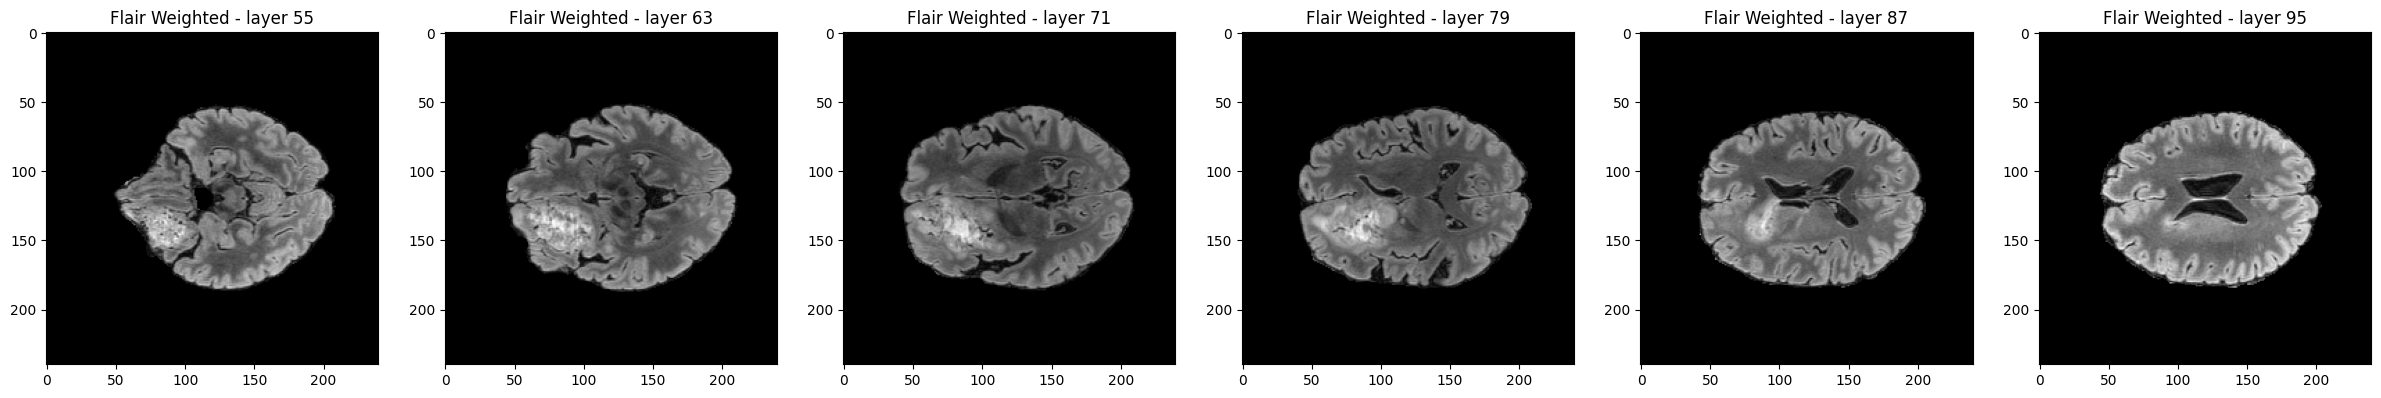

In [7]:
def visualize_MRI_slice(path, ax, layer, i, binary=False):
    if(binary):
        image = nib.load(path).get_fdata() != 0
    else:
        image = nib.load(path).get_fdata()
    ax[i].imshow(image[:, :, layer], cmap='gray')

number_of_images_to_visualize = 6

fig,axs = plt.subplots(1,number_of_images_to_visualize,figsize=(30,8))
#the images are all multi-dimensional with different 'slices' of the brain 

sample_flair_path = train_data_path+"/BraTS2021_00000/BraTS2021_00000_flair.nii.gz"
sample_t1_path = train_data_path+"/BraTS2021_00000/BraTS2021_00000_t1.nii.gz"
for i in range(number_of_images_to_visualize):
    visualize_MRI_slice(sample_flair_path, axs, 55+8*i, i)
    axs[i].set_title("Flair Weighted - layer %i" %(55+8*i))


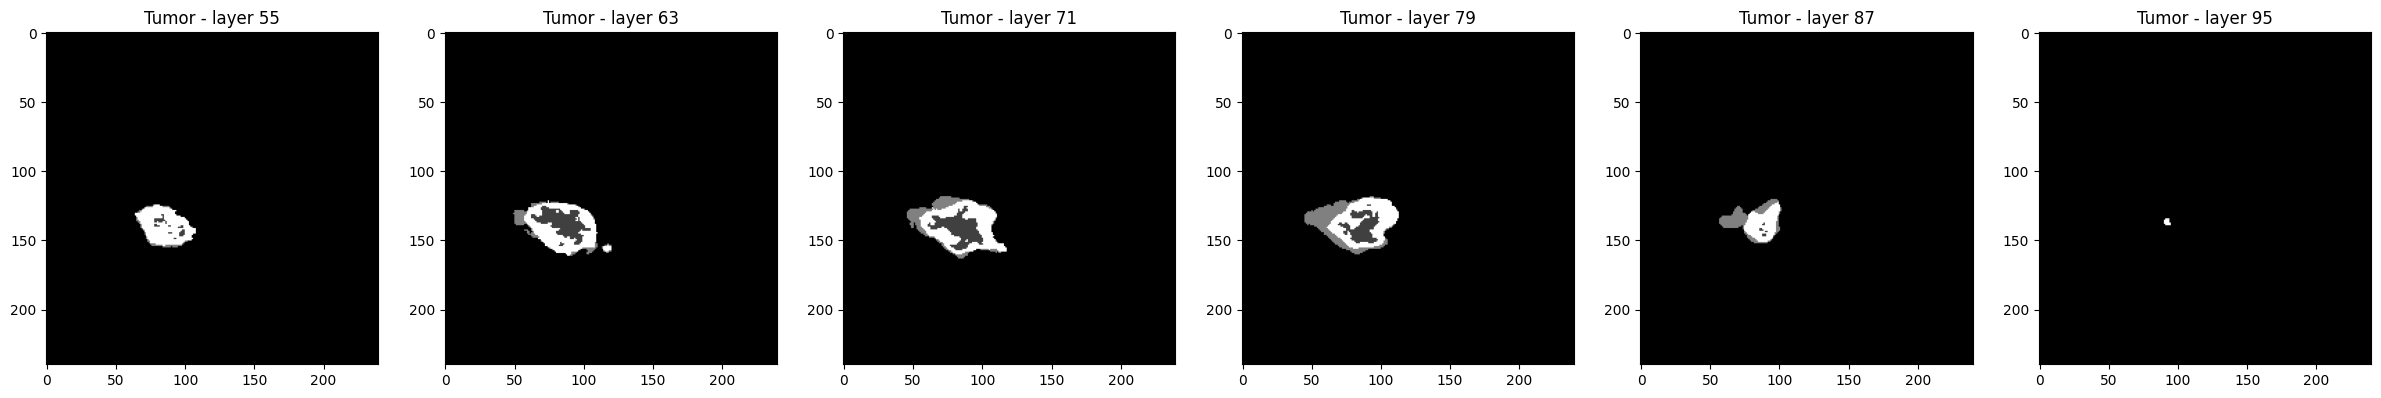

In [8]:
fig,axs = plt.subplots(1,number_of_images_to_visualize,figsize=(30,8))

sample_seg_path = train_data_path+"/BraTS2021_00000/BraTS2021_00000_seg.nii.gz"

for i in range(number_of_images_to_visualize):
    visualize_MRI_slice(sample_seg_path, axs, 55+8*i, i)
    axs[i].set_title("Tumor - layer %i" %(55+8*i))

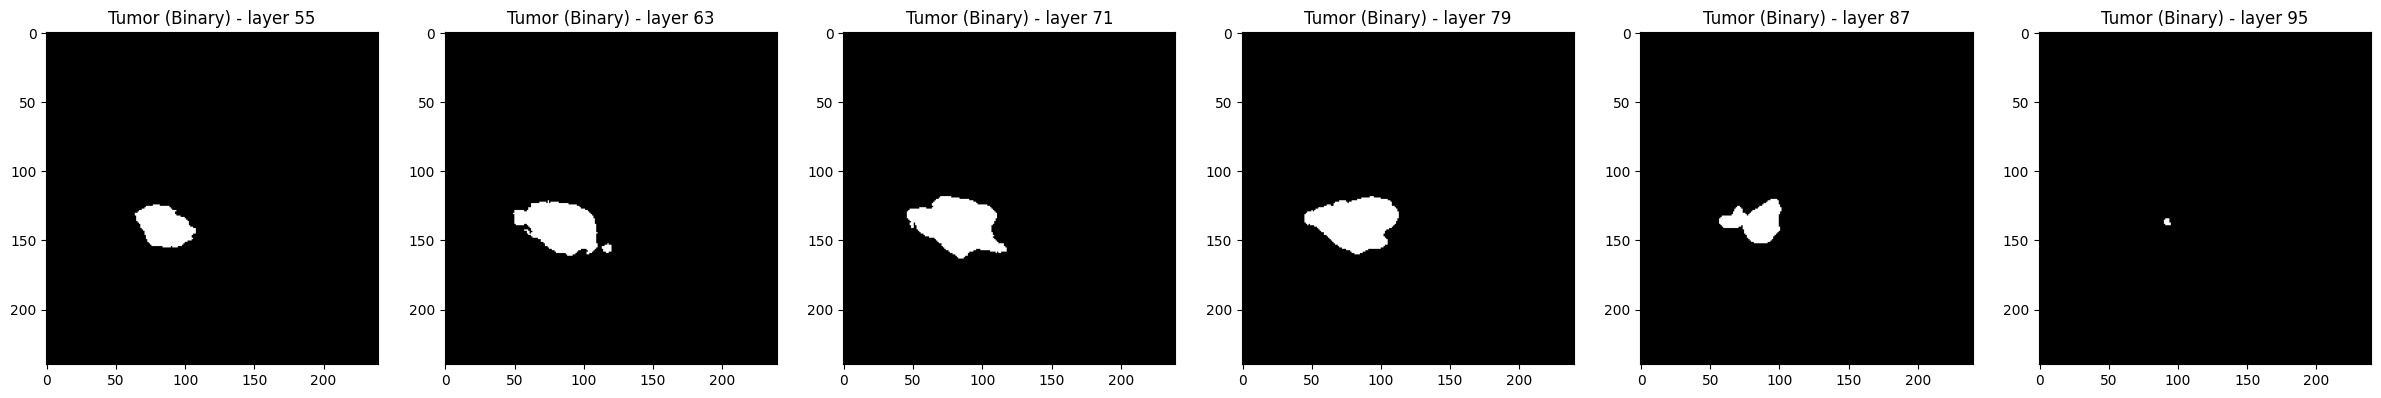

In [9]:
fig,axs = plt.subplots(1,number_of_images_to_visualize,figsize=(30,8))

for i in range(number_of_images_to_visualize):
    visualize_MRI_slice(sample_seg_path, axs, 55+8*i, i, True)
    axs[i].set_title("Tumor (Binary) - layer %i" %(55+8*i))

In [10]:
# DICE(p,o) = 2(p intersect o)/(|p| + |o|)
# The DICE coefficient is used to mesure the effectiveness of the eventual
# classification. 
#
# https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient

def dice(y_true, y_pred, smooth=100):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

# Need to implement these 
def sensitivity(true_masks, predicted_masks):
    return None

def sensitivity(true_masks, predicted_masks):
    return None

def precision(true_masks, predicted_masks):
    return None

def recall(true_masks, predicted_masks):
    return None

In [11]:
feaure_directories = [file.path for file in os.scandir(train_data_path) if file.is_dir()]
train_directories, test_directories = train_test_split(feaure_directories, test_size=.3, random_state=0)
test_directories, val_directories = train_test_split(test_directories,test_size=.5,random_state=0)

def getids(paths):
    x=list()
    for i in range(len(paths)):
        x.append(paths[i][paths[i].rfind('/')+1:])
    return x

train_ids = getids(train_directories)
test_ids = getids(test_directories)
val_ids = getids(val_directories)

In [12]:
from Generators import DataGenerator3D

image_size = 128
classes = {0 : 'NOT tumor',1 : 'NECROTIC/CORE',2 : 'EDEMA', 3 : 'ENHANCING'}
slices = 128 
start = 22

training_generator3D = DataGenerator3D(train_ids,slices,start,image_size,train_data_path)
valid_generator3D = DataGenerator3D(train_ids,slices,start,image_size,train_data_path)
test_generator3D = DataGenerator3D(train_ids,slices,start,image_size,train_data_path)

In [13]:
callbacks = [keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,patience=2, verbose=1, mode='auto'),keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.000001, verbose=1),keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',verbose=1, save_best_only=True, save_weights_only = True)]

def conv_block(input_mat,num_filters,kernel_size,batch_norm):
    X = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(input_mat)
    if batch_norm:
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        X = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(X)
    if batch_norm:
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        X = add([input_mat,X]);
    return X

def Vnet_3dNoScale(input_img, n_filters = 8, dropout = 0.2, batch_norm = True):
    c1 = Conv3D(n_filters,kernel_size = (5,5,5) , strides = (1,1,1) , padding='same')(input_img)
    c2 = Conv3D(n_filters*2,kernel_size = (2,2,2) , strides = (2,2,2) , padding = 'same' )(c1)
    c3 = conv_block(c2 , n_filters*2,5,True)
    p3 = Conv3D(n_filters*4,kernel_size = (2,2,2) , strides = (2,2,2), padding = 'same')(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv_block(p3, n_filters*4,5,True)
    p4 = Conv3D(n_filters*8,kernel_size = (2,2,2) , strides = (2,2,2) , padding='same')(c4)
    p4 = Dropout(dropout)(p4)
    c5 = conv_block(p4, n_filters*8,5,True)
    p6 = Conv3D(n_filters*16,kernel_size = (2,2,2) , strides = (2,2,2) , padding='same')(c5)
    p6 = Dropout(dropout)(p6)

    p7 = conv_block(p6,n_filters*16,5,True)
    u6 = Conv3DTranspose(n_filters*8, (2,2,2), strides=(2, 2, 2), padding='same')(p7);
    u6 = concatenate([u6,c5]);
    c7 = conv_block(u6,n_filters*16,5,True)
    c7 = Dropout(dropout)(c7)
    u7 = Conv3DTranspose(n_filters*4,(2,2,2),strides = (2,2,2) , padding= 'same')(c7);

    u8 = concatenate([u7,c4]);
    c8 = conv_block(u8,n_filters*8,5,True)
    c8 = Dropout(dropout)(c8)
    u9 = Conv3DTranspose(n_filters*2,(2,2,2),strides = (2,2,2) , padding= 'same')(c8);

    u9 = concatenate([u9,c3]);
    c9 = conv_block(u9,n_filters*4,5,True)
    c9 = Dropout(dropout)(c9)
    u10 = Conv3DTranspose(n_filters,(2,2,2),strides = (2,2,2) , padding= 'same')(c9);

    u10 = concatenate([u10,c1]);
    c10 = Conv3D(n_filters*2,kernel_size = (5,5,5),strides = (1,1,1) , padding = 'same')(u10);
    c10 = Dropout(dropout)(c10)
    c10 = add([c10,u10]);

    outputs = Conv3D(4, (1,1,1), activation='softmax')(c10)

    model = Model(inputs=input_img, outputs=outputs)

    return model

In [14]:
# Code to compile the VNET
input_layer = Input((128,image_size, image_size,2))

network = Vnet_3d(input_layer)
network.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics = ['accuracy',tensorflow.keras.metrics.MeanIoU(num_classes=4)])

NameError: name 'Vnet_3d' is not defined

In [ ]:
history =  network.fit(training_generator3D,epochs=5,steps_per_epoch=len(train_ids),callbacks=callbacks,validation_data = valid_generator3D)  
network.save("model_vnet_2mod.h5")

Epoch 1/5


2023-04-16 17:52:25.343416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


  9/876 [..............................] - ETA: 3:45:15 - loss: 0.1607 - accuracy: 0.9831 - mean_io_u: 0.3750

In [39]:
path = "../data/" + val_ids[0] + "/BraTS2021_01070_flair.nii.gz"

image = nib.load(path).get_fdata()

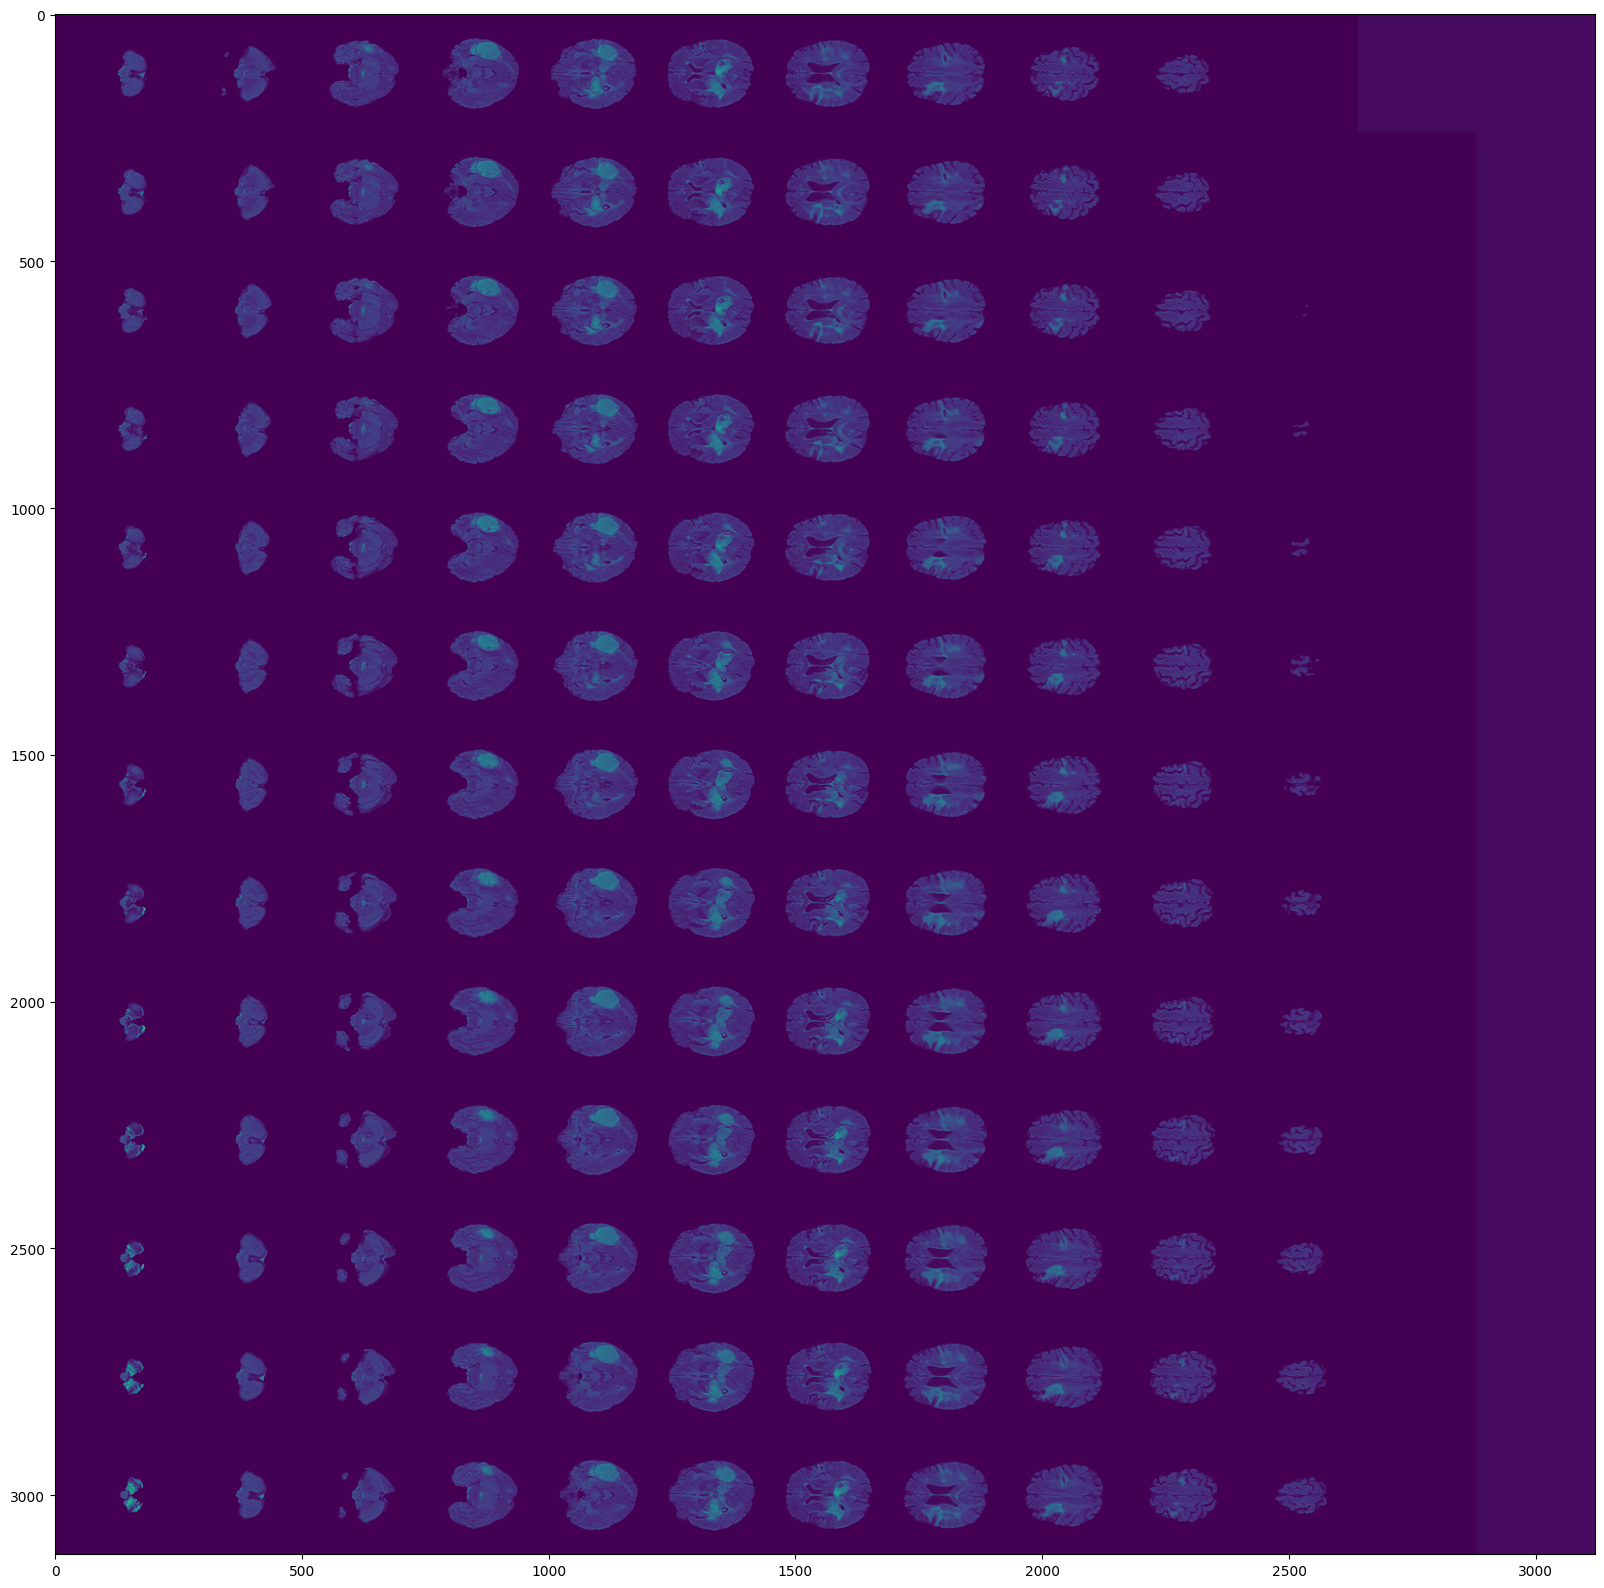

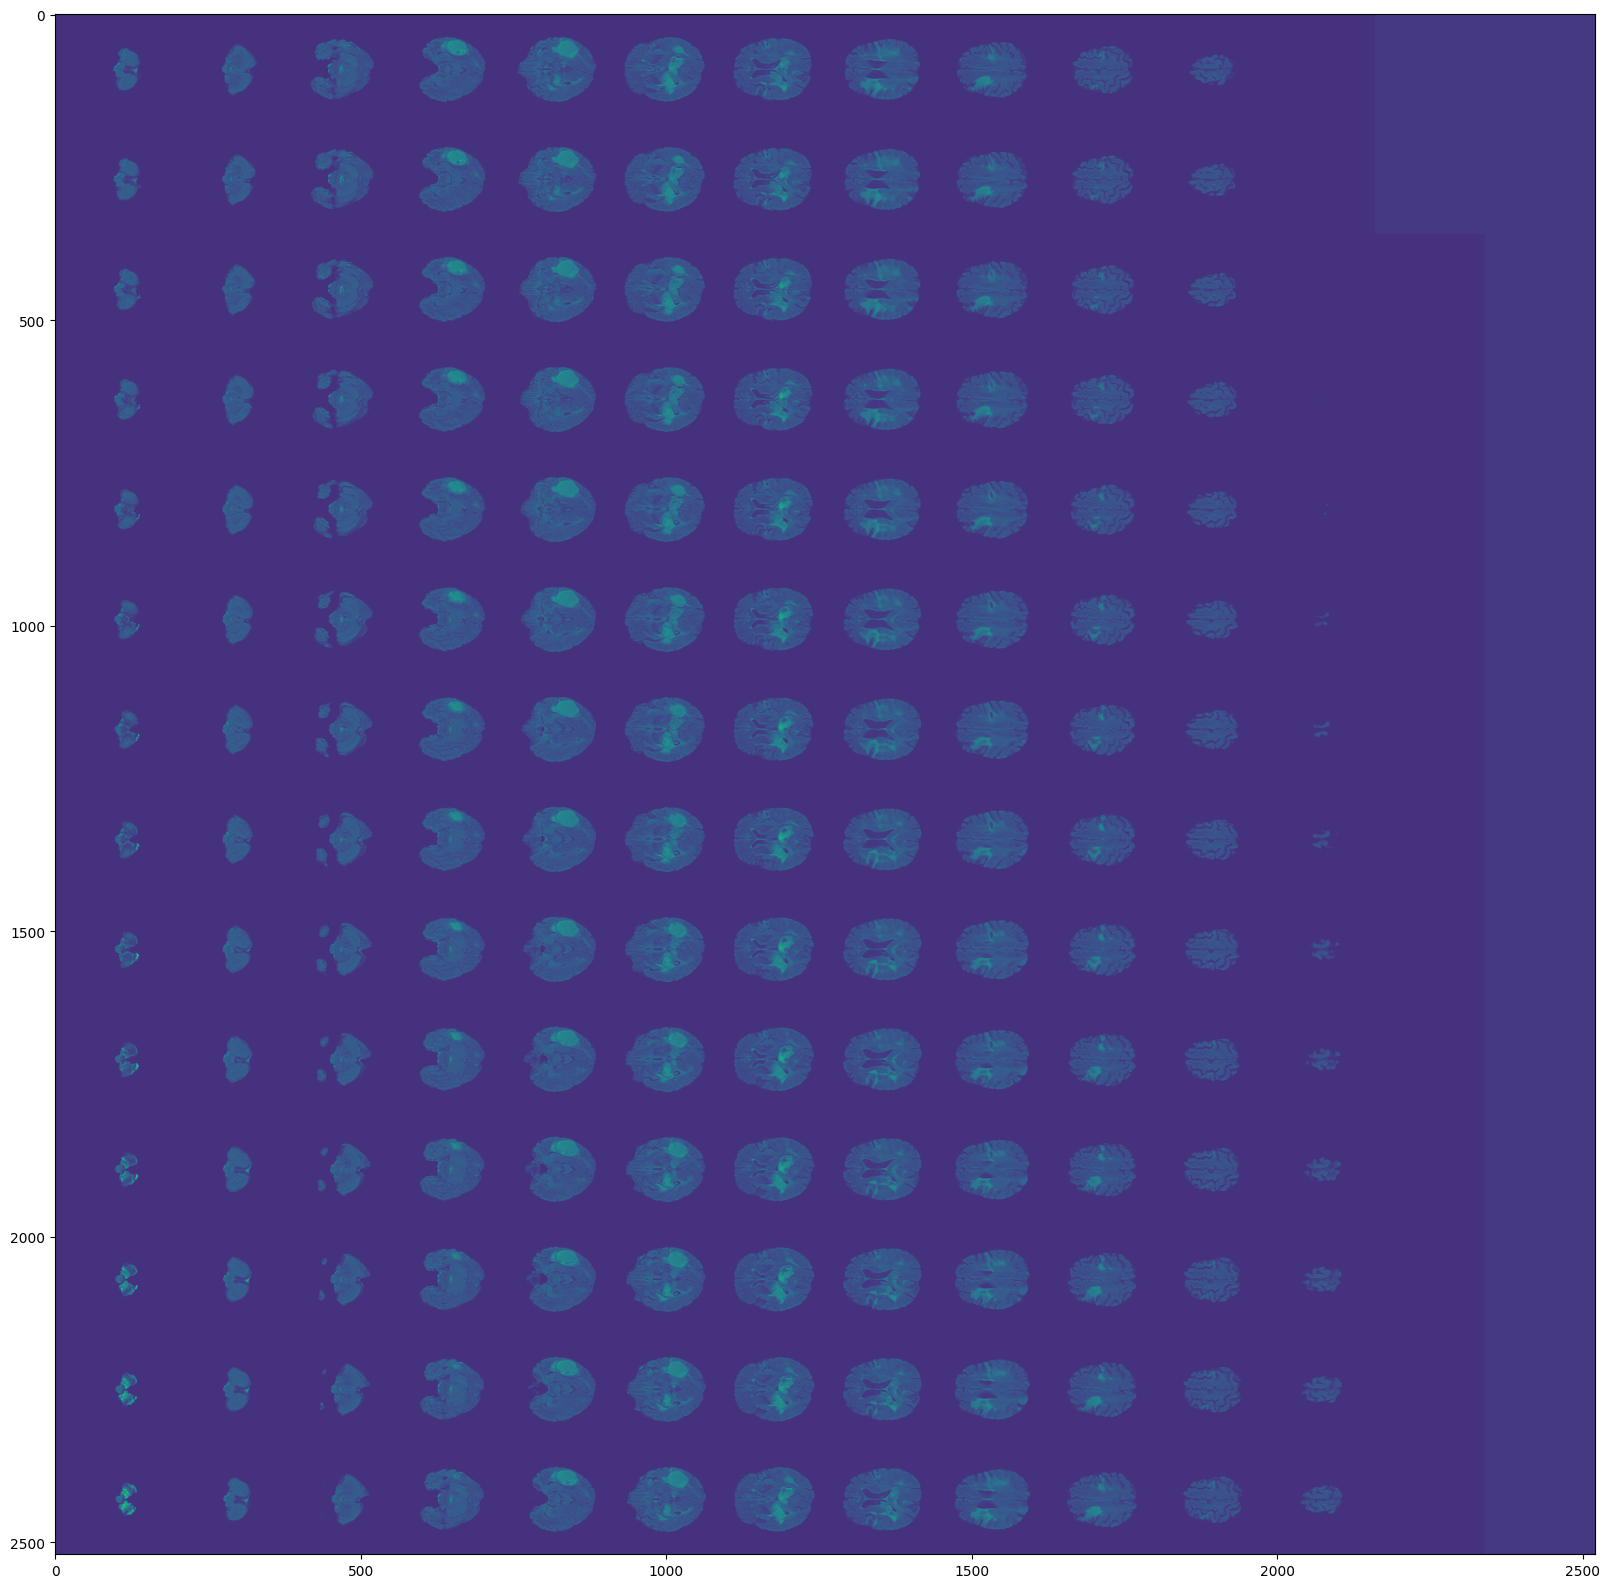

In [43]:
from skimage.util import montage 
from skimage.transform import rotate
from scipy.ndimage import zoom

def imshow3D(img, save=False, path=None):
    if save and path==None:
        print("Error. Cannot save without a valid path.")
        return
    fig,ax = plt.subplots(1, 1, figsize = (20,20))
    ax.imshow(rotate(montage(np.swapaxes(img,0,2)), 90, resize=True))

imshow3D(image)

imshow3D(zoom(image,(180/image.shape[0], 180/image.shape[1], 180/image.shape[2])))


In [44]:
newimg = zoom(image,(180/image.shape[0], 180/image.shape[1], 180/image.shape[2]))

In [46]:
newimg.shape

(180, 180, 180)

In [58]:
def imgshow3D(img, save=False, path=None):
    if save and path==None:
        print("Error. Cannot save without a valid path.")
        return
    fig,ax = plt.subplots(1, 1, figsize = (20,20))
    ax.imshow(rotate(montage(np.swapaxes(img,0,2)), 90, resize=True))

In [65]:
def resize_MRI_image(id):
    ext = ["flair", "t1ce", "t2", "t1", "seg"]
    resimages = []
    for extention in ext:
        pathhhh = "../data/" + id + "/" + id + "_" + extention +".nii.gz"
        ima = nib.load(pathhhh).get_fdata()
        print(ima.shape, 180/ima.shape[0], 180/ima.shape[1], 180/ima.shape[2])
        zoom(ima,(180/ima.shape[0], 180/ima.shape[1], 180/ima.shape[2]))
        resimages += [ima]

    return resimages

In [66]:
images = resize_MRI_image("BraTS2021_00000")


(240, 240, 155) 0.75 0.75 1.1612903225806452
(240, 240, 155) 0.75 0.75 1.1612903225806452
(240, 240, 155) 0.75 0.75 1.1612903225806452
(240, 240, 155) 0.75 0.75 1.1612903225806452
(240, 240, 155) 0.75 0.75 1.1612903225806452


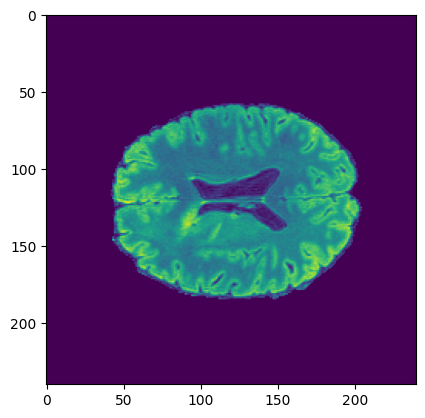

In [74]:
plt.imshow(images[0][:,:,90])